In [24]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from GPVAEmodel import *
from utils import *

In [46]:
import numpy as np
np.unique(np.round(np.linspace(0, 10, 20)))

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

# Restore Model

In [25]:
# for SIN model
# chkpnt_dir = "/home/michael/GPVAE_checkpoints/84:__on__9_10_2019__at__19:15:31/"
SIN_chkpnt_dir = "/run/user/1000/gvfs/sftp:host=godzilla/home/maths/phrnaj/GPVAE_checkpoints/Ayman2/6:SIN_huanan/"
VAE_chkpnt_dir = "/run/user/1000/gvfs/sftp:host=godzilla/home/maths/phrnaj/GPVAE_checkpoints/Ayman2/71:VAE_huanan/"

SIN_chkpnt_dir = "/Users/academic/GPVAE_checkpoints/SIN/"
VAE_chkpnt_dir = "/Users/academic/GPVAE_checkpoints/VAE/"

trainelbo = "SIN"

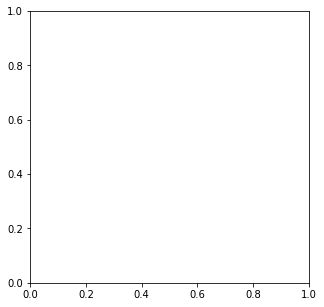

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))

In [27]:
# pic_folder = chkpnt_dir + "pics/"
# res_file = chkpnt_dir + "res/ELBO_pandas"


px = 32
py = 32
r = 3
vid_lt = 5
model_lt = 5.0

# Load test batch from HDD
with open(os.getenv("HOME")+"/GPVAE/Test_Batches.pkl", "rb") as f:
    Test_Batches = pickle.load(f)


def get_qnet(video, model='SIN', post_mean=False):
    """
    args:
        video: (batch, 30, 32,32) np array
        model: 'SIN' or 'VAE'
        post_mean: return qnet or post mean?
    
    returns:
        q_m/p_m: (batch, 30, 2)
    """
    if model=='SIN':
        chkpnt_dir = SIN_chkpnt_dir
        model_lt =5
    else:
        chkpnt_dir = VAE_chkpnt_dir
        model_lt = 0.01

    # Data settings
    batch = video.shape[0]
    tmax = video.shape[1]
    
    # make sure everything is created in the same graph!
    graph = tf.Graph()
    with graph.as_default():

        # Make all the graphs
        beta = tf.compat.v1.placeholder(dtype=tf.float32, shape=())
        vid_batch = build_video_batch_graph(batch=batch, tmax=tmax, px=px, py=py, r=r, lt=vid_lt)
        s_elbo, s_rec, s_pkl, np_elbo, np_rec, np_pkl, \
            p_m,p_v,q_m,q_v,pred_vid, globs = build_sin_and_np_elbo_graphs2(vid_batch, beta, lt=model_lt)

        # The actual loss functions!
        if trainelbo=="SIN":
            loss  = -tf.reduce_mean(s_elbo)
            e_elb = tf.reduce_mean(s_elbo)
            e_pkl = tf.reduce_mean(s_pkl)
            e_rec = tf.reduce_mean(s_rec)
        elif trainelbo=="NP":
            loss  = -tf.reduce_mean(np_elbo)
            e_elb = tf.reduce_mean(np_elbo)
            e_pkl = tf.reduce_mean(np_pkl)
            e_rec = tf.reduce_mean(np_rec)

        av_s_elbo = tf.reduce_mean(s_elbo)
        av_s_rec  = tf.reduce_mean(s_rec)
        av_s_pkl  = tf.reduce_mean(s_pkl)


        # Add optimizer ops to graph (minimizing neg elbo!), print out trainable vars
        global_step = tf.Variable(0, name='global_step',trainable=False)
        optimizer  = tf.compat.v1.train.AdamOptimizer()
        train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        optim_step = optimizer.minimize(loss=loss, 
                                        var_list=train_vars,
                                        global_step=global_step)



        # Initializer ops for the graph and saver
        init_op = tf.global_variables_initializer()
        saver = tf.compat.v1.train.Saver()


        # Results to be tracked and Pandas saver
        res_vars = [global_step,
                    loss,
                    av_s_elbo,
                    av_s_rec,
                    av_s_pkl,
                    e_elb,
                    e_rec,
                    e_pkl,
                    tf.math.reduce_min(q_v),
                    tf.math.reduce_max(q_v),
                    tf.math.reduce_min(p_v),
                    tf.math.reduce_max(p_v)]
        res_names= ["Step",
                    "Loss",
                    "Test ELBO",
                    "Test Reconstruction",
                    "Test Prior KL",
                    "Train ELBO",
                    "Train Reconstruction",
                    "Train Prior KL",
                    "min qs_var",
                    "max qs_var",
                    "min q_var",
                    "max q_var",
                    "MSE",
                    "Beta",
                    "Time"]
#         res_saver = pandas_res_saver(res_file, res_names)

        # Now let's start doing some computation!
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
        with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:

            # Attempt a restore weights
#             try:
            saver.restore(sess, tf.train.latest_checkpoint(chkpnt_dir))
            print("\n\nRestored Model Weights")
#             except:
#                 sess.run(init_op)
#                 print("\n\nInitialised Model Weights")

            # Start training that elbo!
            for t in range(1):

                # get training step
                g_s = sess.run(global_step, {beta:1.0})

                # Print out diagnostics/tracking
                TD = video
                test_elbo, e_rec_i, e_pkl_i = sess.run([e_elb, e_rec, e_pkl], {vid_batch:TD, beta:1.0})
                test_qv, test_pv, test_pm, test_qm = sess.run([q_v, p_v, p_m, q_m], {vid_batch:TD, beta:1.0})

                print(str(g_s)+": elbo "+str(test_elbo)+"\t "+"\t "+str(e_rec_i)+"  "+str(e_pkl_i)+\
                ",\t\t qvar range:\t",str(test_pv.max()),"\t",str(test_qv.min()) ,\
                ",\t\t qmean range:\t",str(np.abs(test_pm).max()),"\t",str(np.abs(test_qm).max())  )
                
                if post_mean:
                    return test_pm
                else:
                    return test_qm


                # Save elbo, recon, priorKL....
                if False:
                    TT, TD = Test_Batches[0]
                    p_m_i, p_v_i = sess.run([p_m, p_v], {vid_batch:TD, beta:1})
                    _, _, MSE, _ = MSE_rotation(p_m_i, TT, p_v_i)
                    new_res = sess.run(res_vars, {vid_batch:TD, beta:1})
                    new_res += [MSE, beta_t, time.time()]
#                     res_saver(new_res)


                # Save plot
                if False:
                    fig, ax = plt.subplots(6,3, figsize=(6, 8))
                    TT, TD = Test_Batches[0]
                    reconpath, reconvar, reconvid = sess.run([p_m, p_v, pred_vid], {vid_batch:TD, beta:1})
                    rp, _, MSE, rv = MSE_rotation(reconpath, TT, reconvar)
                    _ = plot_latents(TD, TT, reconvid, rp, rv, ax=ax, nplots=6)
                    plt.tight_layout()
                    plt.draw()
                    # plt.show()
                    plt.pause(0.01)
                    plt.savefig(pic_folder + str(g_s)+".pdf")
                    plt.close(fig)



# Utilities

In [28]:
def pixelate_series(traj0):
    """
    Makes a video from a series of x,y, pairs
    args:
        traj0: (tmax, 2) np array
        
    returns:
        vid: (tmax, 32, 32) np array
    """
    px = 32
    py = 32
    r = 3

    
    def pixelate_frame(xy):
        """
        takes a single x,y pixel point and converts to binary image
        with ball centered at x,y.
        """
        rr = r*r
        x = xy[0]
        y = xy[1]

        sq_x = (np.arange(px) - x)**2
        sq_y = (np.arange(py) - y)**2

        sq = sq_x.reshape(1,-1) + sq_y.reshape(-1,1)

        image = 1*(sq < rr)

        return image


    XY = traj0.copy()

    # convert trajectories to pixel dims
    XY[:,0] = XY[:,0] * (px/5) + (0.5*px)
    XY[:,1] = XY[:,1] * (py/5) + (0.5*py)

    vid = map(pixelate_frame, XY)
    vid = [v for v in vid]
    return np.asarray(vid)
    
    
def add_dim(nparray):
    s = list(nparray.shape)
    return nparray.reshape([1]+s)



def plot_heatmap(vid, ax):
    """
    args:
        vid: tmax, px, py
    returns:
        flat_vid: px, py
    """
    vid = np.array([(t+4)*v for t,v in enumerate(vid)])
    flat_vid = 1-np.max(vid, 0)*(1/(4+30))
    ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
        right=False,
        labelleft=False,
    labelbottom=False)
    ax.imshow(flat_vid, cmap='Greys',origin='lower')

# Make Web of Points

In [29]:
n_in = 8
n_ot = 10

x_r = [[0], 
       np.sin(2*np.pi*np.arange(n_in)/n_in), 
       2*np.sin(2*np.pi*np.arange(n_ot)/n_ot)]
x_r = np.concatenate(x_r)

y_r = [[0], 
       np.cos(2*np.pi*np.arange(n_in)/n_in), 
       2*np.cos(2*np.pi*np.arange(n_ot)/n_ot)]
y_r = np.concatenate(y_r)

traj0 = np.vstack([x_r, y_r]).T

traj00 = np.concatenate([traj0, traj0], axis=0)
traj00 = traj00[:30,:].reshape((1,30,2))

print('traj shape:', traj00.shape)

V_c = pixelate_series(traj00[0,:,:])
V_c = add_dim(V_c)
print("video shape:" , V_c.shape)

# fig, ax = plt.subplots(figsize=(5,5))

# plot_heatmap(V_c[0,:,:,:], ax)

       

traj shape: (1, 30, 2)
video shape: (1, 30, 32, 32)


In [30]:
def plot_circle(qnet_m, ax):
    
    ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False)
        

    rot_qnet, _, _, _ = MSE_rotation(qnet_m, traj00)


    ax.scatter(traj0[:,0],traj0[:,1],color='blue')

    ax.plot(traj0[1:9,0], traj0[1:9,1], color='blue')
    t_x1 = np.array([traj0[1,0], traj0[8,0]])
    t_y1 = np.array([traj0[1,1], traj0[8,1]])
    ax.plot(t_x1, t_y1, color='blue')

    ax.plot(traj0[9:19,0], traj0[9:19,1],color='blue')
    t_x2 = np.array([traj0[9,0], traj0[18,0]])
    t_y2 = np.array([traj0[9,1], traj0[18,1]])
    ax.plot(t_x2, t_y2, color='blue')
    
    
    ax.scatter(rot_qnet[0,:,0],rot_qnet[0,:,1],color= 'orange', zorder=10)
        
    ax.plot(rot_qnet[0,1:9,0], rot_qnet[0,1:9,1], color='orange', zorder=10)
    q_x1 = np.array([rot_qnet[0,1,0], rot_qnet[0,8,0]])
    q_y1 = np.array([rot_qnet[0,1,1], rot_qnet[0,8,1]])
    ax.plot(q_x1, q_y1, color='orange', zorder=10)

    ax.plot(rot_qnet[0,9:19,0], rot_qnet[0,9:19,1],color='orange', zorder=10)
    q_x2 = np.array([rot_qnet[0,9,0], rot_qnet[0,18,0]])
    q_y2 = np.array([rot_qnet[0,9,1], rot_qnet[0,18,1]])
    ax.plot(q_x2, q_y2, color='orange', zorder=10)







In [31]:
# Get the numbers!
qnet_m_sin = get_qnet(V_c, model='SIN')
qnet_m_vae = get_qnet(V_c, model='VAE')


INFO:tensorflow:Restoring parameters from /Users/academic/GPVAE_checkpoints/SIN/model-50000


Restored Model Weights
50000: elbo -8799.515	 	 -6620.329  -2179.1855,		 qvar range:	 0.0005443692 	 0.00014875675 ,		 qmean range:	 3.1782227 	 3.4309077
INFO:tensorflow:Restoring parameters from /Users/academic/GPVAE_checkpoints/VAE/model-50000


Restored Model Weights
50000: elbo -23973.703	 	 -22371.504  -1602.1992,		 qvar range:	 0.00047057867 	 2.7405771e-05 ,		 qmean range:	 1.3727007 	 2.788419


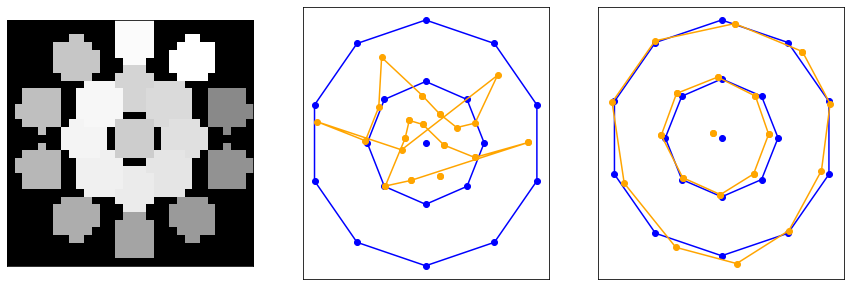

In [32]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

plot_heatmap(V_c[0,:,:,:], ax[0])
plot_circle(qnet_m_vae, ax[1])
plot_circle(qnet_m_sin, ax[2])

# Square plotting function

In [33]:
def plot_square(q_sq, ax):
    rot_qsq, _, _, _ = MSE_rotation(q_sq, add_dim(sq_tr))

    rot_qsq = rot_qsq[0, :, :]


    ax.scatter(sq_tr[:,0], sq_tr[:,1], color='blue')

    ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
        right=False,
        labelleft=False,
    labelbottom=False)
    


    for i in range(5):
        for j in range(4):
#             dx = np.array( [rot_qsq[i+5*j, 0], rot_qsq[i+5*(j+1), 0]] )
#             dy = np.array( [rot_qsq[i+5*j, 1], rot_qsq[i+5*(j+1), 1]] )
#             ax.plot(dx, dy, color='orange')

#             dx = np.array( [rot_qsq[j+5*i, 0], rot_qsq[1+j+5*i, 0]] )
#             dy = np.array( [rot_qsq[j+5*i, 1], rot_qsq[1+j+5*i, 1]] )
#             ax.plot(dx, dy, color='orange')


            dx = np.array( [sq_tr[i+5*j, 0], sq_tr[i+5*(j+1), 0]] )
            dy = np.array( [sq_tr[i+5*j, 1], sq_tr[i+5*(j+1), 1]] )
            ax.plot(dx, dy, color='blue')

            dx = np.array( [sq_tr[j+5*i, 0], sq_tr[1+j+5*i, 0]] )
            dy = np.array( [sq_tr[j+5*i, 1], sq_tr[1+j+5*i, 1]] )
            ax.plot(dx, dy, color='blue')
            
    ax.scatter(rot_qsq[:, 0],rot_qsq[:, 1], color='orange', zorder=10)
    for i in range(5):
        for j in range(4):
            dx = np.array( [rot_qsq[i+5*j, 0], rot_qsq[i+5*(j+1), 0]] )
            dy = np.array( [rot_qsq[i+5*j, 1], rot_qsq[i+5*(j+1), 1]] )
            ax.plot(dx, dy, color='orange', zorder=10)

            dx = np.array( [rot_qsq[j+5*i, 0], rot_qsq[1+j+5*i, 0]] )
            dy = np.array( [rot_qsq[j+5*i, 1], rot_qsq[1+j+5*i, 1]] )
            ax.plot(dx, dy, color='orange', zorder=10)


#             dx = np.array( [sq_tr[i+5*j, 0], sq_tr[i+5*(j+1), 0]] )
#             dy = np.array( [sq_tr[i+5*j, 1], sq_tr[i+5*(j+1), 1]] )
#             ax.plot(dx, dy, color='blue')

#             dx = np.array( [sq_tr[j+5*i, 0], sq_tr[1+j+5*i, 0]] )
#             dy = np.array( [sq_tr[j+5*i, 1], sq_tr[1+j+5*i, 1]] )
#             ax.plot(dx, dy, color='blue')
        
#         dx = [rot_qsq[] ]
        

# Make a grid of points

In [34]:
base_lin = (np.arange(5)-2) 
sq_x = np.hstack([base_lin for i in range(5)])
sq_y = sq_x.reshape((5,5)).T.reshape((-1))

sq_tr = np.vstack([sq_x, sq_y]).T

sq_tr = np.vstack([sq_tr, sq_tr[:5,:]]) + 0.01

print("sqtr shape: ", sq_tr.shape)

V_sq = pixelate_series(sq_tr)
V_sq = add_dim(V_sq)
print("V_sq shape: ", V_sq.shape)

# plot_heatmap(V_sq[0,:,:,:])

sqtr shape:  (30, 2)
V_sq shape:  (1, 30, 32, 32)


In [35]:
# get the latent representations
q_sq_vae = get_qnet(V_sq, model='VAE')
print(q_sq_vae.shape)

q_sq_sin = get_qnet(V_sq, model='SIN')
print(q_sq_sin.shape)

INFO:tensorflow:Restoring parameters from /Users/academic/GPVAE_checkpoints/VAE/model-50000


Restored Model Weights
50000: elbo -45073.83	 	 -42780.055  -2293.7734,		 qvar range:	 0.0025274754 	 3.468788e-05 ,		 qmean range:	 5.7010016 	 4.3716736
(1, 30, 2)
INFO:tensorflow:Restoring parameters from /Users/academic/GPVAE_checkpoints/SIN/model-50000


Restored Model Weights
50000: elbo -40719.848	 	 -38969.242  -1750.6055,		 qvar range:	 0.0014605522 	 0.00017012356 ,		 qmean range:	 4.031952 	 4.872414
(1, 30, 2)


# Plot circles and Squares together

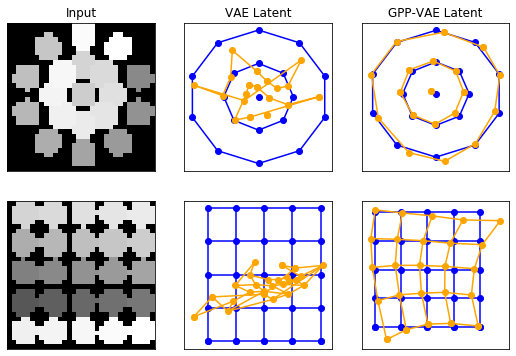

In [36]:
fig, axi = plt.subplots(2,3, figsize=(9,6))

ax = axi[0]
plot_heatmap(V_c[0,:,:,:], ax[0]); ax[0].set_title('Input')
plot_circle(qnet_m_vae, ax[1]); ax[1].set_title('VAE Latent')
plot_circle(qnet_m_sin, ax[2]); ax[2].set_title('GPP-VAE Latent')

ax = axi[1]
plot_heatmap(V_sq[0,:,:,:], ax[0])
plot_square(q_sq_vae, ax[1])
plot_square(q_sq_sin, ax[2])

fig.savefig("/Users/academic/AABI_plots/circle_square_latent.pdf")

# Plot video and latents

In [37]:
# Get the numbers!
pm_SIN  = get_qnet(video=Test_Batches[0][1], model='SIN', post_mean=True)
pm_VAE = get_qnet(video=Test_Batches[0][1], model='VAE', post_mean=True)

INFO:tensorflow:Restoring parameters from /Users/academic/GPVAE_checkpoints/SIN/model-50000


Restored Model Weights
50000: elbo -160.08493	 	 -75.79774  -84.2872,		 qvar range:	 0.56458354 	 0.00011888822 ,		 qmean range:	 6.0442944 	 5.2525115
INFO:tensorflow:Restoring parameters from /Users/academic/GPVAE_checkpoints/VAE/model-50000


Restored Model Weights
50000: elbo -4587.631	 	 -4185.8193  -401.81168,		 qvar range:	 0.013214946 	 2.3327619e-05 ,		 qmean range:	 4.385336 	 4.2576823


In [38]:
pm_SIN, _,_,_ = MSE_rotation(pm_SIN, Test_Batches[0][0])
pm_VAE, _,_,_ = MSE_rotation(pm_VAE, Test_Batches[0][0])

In [41]:
def plot_latent_path(pm, tr, ax, leg=False, axes=False):
    """
    Plot true lines and learnt lines
    
    args:
        pm: (tmax, 2) np array
        tr: (tmax, 2) np array
        ax: matplotlib axes
        
    returns:
         NULL
    """
    if axes:
        ax.set_xlabel("x") 
        ax.set_ylabel("y")
    else:
        ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
            right=False,
            labelleft=False,
        labelbottom=False)

    ax.set_xlim([-2.5,2.5])
    ax.set_ylim([-2.5,2.5])

    dx = tr[-1,0] - tr[-2,0]
    dy = tr[-1,1] - tr[-2,1]  
#     ax.scatter(tr[-1,0], tr[-1,1], color='blue')
    ax.arrow(tr[-1,0], tr[-1,1], dx, dy, color='blue', width=0.0001,head_width=0.3)
    ax.plot(tr[:,0], tr[:,1], color='blue', label="Truth")

    
    dx_pm = pm[-1,0] - pm[-2,0]
    dy_pm = pm[-1,1] - pm[-2,1]  
#     ax.scatter(pm[-1,0], pm[-1,1], color='orange', zorder=10)
#     ax.arrow(pm[-1,0], pm[-1,1], dx_pm, dy_pm, color='orange', width=0.0001,head_width=0.3)
#     ax.plot(pm[:,0], pm[:,1], color='orange', zorder=10, label=r'$q(x_{1:T}, y_{1:T}|v_{1:T})$')
    
    if leg:
        ax.legend(ncol=1)

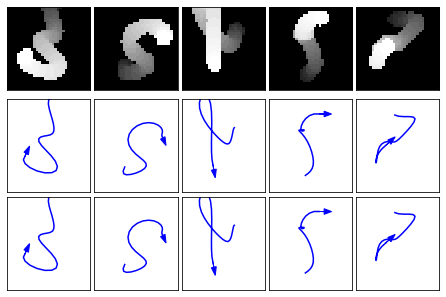

In [42]:
fig, ax = plt.subplots(3,5, figsize = (6, 4))
# fig.tight_layout()

fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.05, hspace=0.05)

for i in range(5):
    
    plot_heatmap(Test_Batches[0][1][i,:,:,:], ax[0][i])
    plot_latent_path(pm_VAE[i,:,:], Test_Batches[0][0][i,:], ax[1][i])
    plot_latent_path(pm_SIN[i,:,:], Test_Batches[0][0][i,:], ax[2][i])

fig.savefig("/Users/academic/AABI_plots/vid_latents.pdf")

# Function to plot GP Sausages

In [18]:
def plot_sausage(x, ax, ylabel, truth=None):
    
    SE = lambda t1, t2: np.exp(-0.5 * (t1[:,None] - t2[None,:])**2 / 25)
    
    T = np.arange(30)
    K = SE(T, T) + 0.0001*np.eye(30)
    iK = np.linalg.inv(K)
    iKY = np.matmul(iK, x[:,None])
    
    post_var = lambda t: 1.- np.matmul(SE(t,T), np.matmul(iK, SE(T, t)))[0,0]
    post_mean = lambda t: np.squeeze( np.matmul(SE(t,T), iKY) )
    
    T_plot = np.linspace(-5, 35, num=100)
    X_plot = post_mean(T_plot)
    X_se = 2*np.sqrt([post_var(ti[None]) for ti in T_plot])
    
    if ylabel == "x":
        legend_label1 = r'$\mu^*_x(v_{1:T})$'
        legend_label2 = r'$\mu_x(t)$'
    else:
        legend_label1 = r'$\mu^*_y(v_{1:T})$'
        legend_label2 = r'$\mu_y(t)$'        

    ax.scatter(T, x, color="orange", label=legend_label1, alpha=0.5)
    ax.plot(T_plot, X_plot, color="orange", label=legend_label2, alpha=0.5)

    ax.set_ylim((-2.5, 2.5))
    ax.set_xlabel("Time, t")
    ax.set_ylabel(ylabel)
    
    if truth is not None:
        ax.plot(T, truth, color="blue", label="Truth", zorder=0)
        han, lab = ax.get_legend_handles_labels()
        han = [han[1], han[2], han[0]]
        lab = [lab[1], lab[2], lab[0]]
    else:
        han, lab = ax.get_legend_handles_labels()
            


    ax.fill_between(T_plot, X_plot+X_se, X_plot-X_se, alpha=0.2, color="orange")


    ax.legend(han, lab)

# plot GP for each dimension

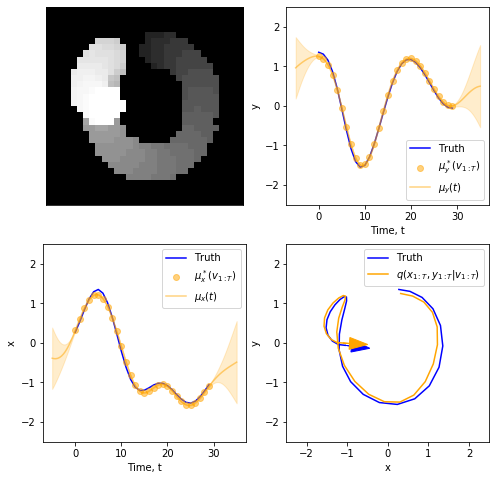

In [23]:
# fig, ax = plt.subplots(1,4, figsize = (15, 2.99))
fig, ax = plt.subplots(2,2, figsize = (8, 8))
# fig.tight_layout()

# fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.05, hspace=0.05)

i = 5
plot_heatmap(Test_Batches[0][1][i,:,:,:], ax[0][0])
plot_latent_path(pm_SIN[i,:,:], Test_Batches[0][0][i,:], ax[1][1], leg=True, axes=True)
plot_sausage(pm_SIN[i,:,1], ax[0][1], "y", Test_Batches[0][0][i,:][:,1])
plot_sausage(pm_SIN[i,:,0], ax[1][0], "x", Test_Batches[0][0][i,:][:,0])

fig.savefig("/Users/academic/AABI_plots/vid_latents_GP.pdf",bbox_inches = 'tight')

(19, 21)

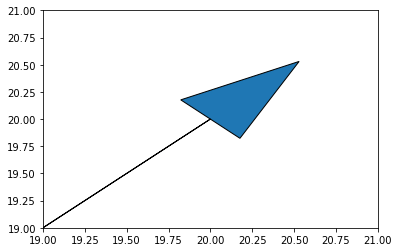

In [20]:
fig, ax = plt.subplots(1,1)

ax.arrow(10,10,10,10, head_width=0.5)
ax.set_xlim((19, 21))
ax.set_ylim((19, 21))
